In [1]:
# to get started, we will import these libraries
import urllib.request, json 
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from sodapy import Socrata

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
# next we will connect to the data portal to load in vacant parcel data from LA County Assessor
client = Socrata("data.lacounty.gov", None)

# The website says this dataset has 176K rows, we are going to try to call in all of them using 180K in case more have been added. However, we are also going to limit our data to Los Angeles incorporated
results = client.get("vcaw-zeg9", limit=180000, where="taxratearea_city=='LOS ANGELES'")

# We'll need to convert to pandas DataFrame
vacdf = pd.DataFrame.from_records(results)

vacdf.sample(5)

,usecodedescchar1,roll_homeownersexemp,situsunit,recordingdate,effectiveyearbuilt,istaxableparcel,roll_totlandimp,roll_perspropexemp,parcelboundarydescription,roll_landbaseyear,...,location_1,bathrooms,sqftmain,situsdirection,roll_realestateexemp,center_lat,situszip,yearbuilt,propertylocation,situszip5
6652,Residential,0,,20120927,0,Y,30738,0,TR=19383 FOR DESC SEE ASSESSOR'S MAPS POR OF L...,2013,...,"{'latitude': '34.23279505', 'needs_recoding': ...",0,0,,0,34.23279505,,0,NaN,NaN
1685,Residential,0,,19900309,0,Y,202979,0,TRACT # 1000 E 82.5 FT OF W 165 FT OF N 300 FT...,1989,...,"{'latitude': '34.20061786', 'needs_recoding': ...",0,0,,202979,34.20061786,91405-2214,0,14720 SHERMAN WAY LOS ANGELES CA 91405,91405
32998,Residential,0,,20120504,0,Y,191340,0,TRACT # 8722 LOT 48,1990,...,"{'latitude': '34.20202577', 'needs_recoding': ...",0,0,,0,34.20202577,91303-1739,0,7229 LOMA VERDE AVE LOS ANGELES CA 91303,91303
30847,Industrial,0,,20051007,0,Y,5682,0,WILMINGTON 111 ACRE RANGE LOT COM AT INTERSE...,2006,...,"{'latitude': '33.79440924', 'needs_recoding': ...",0,0,,0,33.79440924,,0,NaN,NaN
4064,Residential,0,,19870423,0,Y,4384,0,TRACT NO 3923 EX OF ST LOT 4008,1987,...,"{'latitude': '34.25677137', 'needs_recoding': ...",0,0,,0,34.25677137,,0,NaN,NaN


In [3]:
# we need to replace null objects with "n/a" in order to analyze and plot this important data on the designated use type of these parcels later
vacdf['usecodedescchar1'].fillna('N/A')

0         Industrial
1        Residential
2        Residential
3        Residential
4        Residential
            ...     
33086    Residential
33087    Residential
33088    Residential
33089     Commercial
33090    Residential
Name: usecodedescchar1, Length: 33091, dtype: object

In [4]:
# we will need to convert our df to gdf. Since data is in lat/lon's we will assign crs to WGS84 (epsg:4326)
vacgdf = gpd.GeoDataFrame(vacdf, 
                       crs='epsg:4326',
                       geometry=gpd.points_from_xy(vacdf.center_lon, vacdf.center_lat))

In [5]:
# importing our community boundaries dataset by referencing API from data source and using shapely to convert the geometries

import shapely
from shapely.geometry import shape

comdf = pd.read_json( r'https://data.lacounty.gov/resource/frhs-h972.json' )
comdf = comdf[comdf["lcity"].str.contains("Los Angeles") == True]
comdf['the_geom'] = comdf['the_geom'].apply(shape)
comgdf = gpd.GeoDataFrame(comdf).set_geometry('the_geom')

comgdf.sample(5)

,objectid,city_type,lcity,label,source,shape_starea,shape_stlength,the_geom,community
120,54,City,Los Angeles,Los Angeles - Bel Air,LA City,1.865802e+08,76705.397402,"MULTIPOLYGON (((-118.45961 34.13048, -118.4585...",Bel Air
257,155,City,Los Angeles,Los Angeles - Thai Town,LA City,6.113947e+06,10572.174517,"MULTIPOLYGON (((-118.30054 34.10176, -118.3005...",Thai Town
307,165,City,Los Angeles,Los Angeles - Venice,LA City,7.791742e+07,42922.869737,"MULTIPOLYGON (((-118.44336 33.99531, -118.4433...",Venice
334,184,City,Los Angeles,Los Angeles - Woodland Hills,LA City,4.113293e+08,122458.394067,"MULTIPOLYGON (((-118.61464 34.19150, -118.6146...",Woodland Hills
319,112,City,Los Angeles,Los Angeles - Longwood,LA City,6.570203e+06,13147.195585,"MULTIPOLYGON (((-118.33980 34.03984, -118.3387...",Longwood


In [6]:
# setting projection so we can map this

comgdf = comgdf.set_crs('epsg:4326')

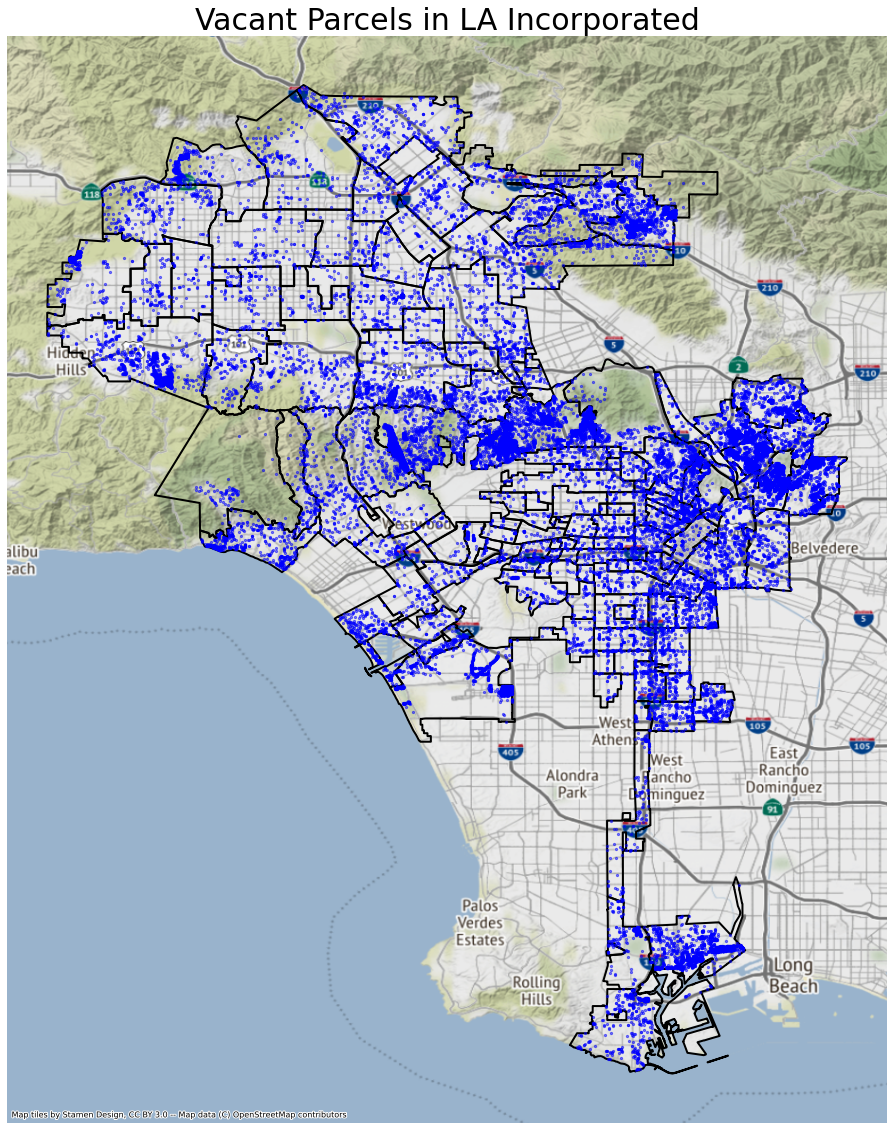

In [50]:
# to map vacant parcels
fig, ax = plt.subplots(figsize=(20,20))

comgdf.plot(ax=ax, edgecolor='k',linewidth=2, color='none')

vacgdf.plot(ax=ax, markersize=5,
                      color='blue',
            alpha=0.5)

# keeping the axis on for now and will turn off later
ax.axis('off')

ax.set_title('Vacant Parcels in LA Incorporated',fontsize=30)

# we are interested in seeing LA county map features and will use this basemap
ctx.add_basemap(ax, source=ctx.providers.Stamen.Terrain, crs=vacgdf.crs)

plt.savefig('VacantParcels_LA City_All.png', bbox_inches='tight')

In [8]:
treegdf = gpd.read_file("Data/blackwalnut.geojson")

In [9]:
helptreegdf = gpd.read_file("Data/blackwalnut_2080.geojson")

In [10]:
treegdf

,cartodb_id,id,gridcode,geometry
0,87,100,1,"MULTIPOLYGON (((-120.40990 35.32800, -120.4437..."
1,464,790,1,"MULTIPOLYGON (((-116.05168 31.44543, -116.0624..."
2,202,277,1,"MULTIPOLYGON (((-119.54383 34.56215, -119.5550..."
3,203,278,1,"MULTIPOLYGON (((-119.98183 34.45184, -119.9929..."
4,204,280,1,"MULTIPOLYGON (((-118.76262 34.68057, -118.7653..."
...,...,...,...,...
509,513,866,1,"MULTIPOLYGON (((-115.89801 30.50364, -115.9002..."
510,514,867,1,"MULTIPOLYGON (((-115.89801 30.50364, -115.8957..."
511,497,849,1,"MULTIPOLYGON (((-115.89269 30.98425, -115.9141..."
512,498,850,1,"MULTIPOLYGON (((-116.03608 30.93336, -116.0575..."


In [11]:
treegdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

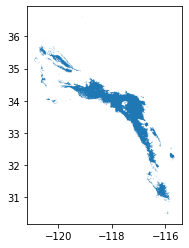

In [12]:
treegdf.plot()

In [33]:
color = helptreegdf.loc[helptreegdf['ncar_2080'] == 'stable', 'color'] = 'yellow'
helptreegdf.loc[helptreegdf['ncar_2080'] == 'loss', 'color'] = 'red'
helptreegdf.loc[helptreegdf['ncar_2080'] == 'gain', 'color'] = 'green'

helptreegdf

,cartodb_id,ncar_2080,geometry,color
0,1,stable,"MULTIPOLYGON (((-115.97922 31.01323, -115.9746...",yellow
1,2,loss,"MULTIPOLYGON (((-115.89801 30.50364, -115.9002...",red
2,3,gain,"MULTIPOLYGON (((-116.07807 31.00529, -116.0759...",green


In [14]:
elsereno = comgdf[comgdf["community"].str.contains("El Sereno") == True]
elsereno

,objectid,city_type,lcity,label,source,shape_starea,shape_stlength,the_geom,community
116,78,City,Los Angeles,Los Angeles - El Sereno,LA City,1.090510e+08,57287.733092,"MULTIPOLYGON (((-118.15536 34.09867, -118.1553...",El Sereno


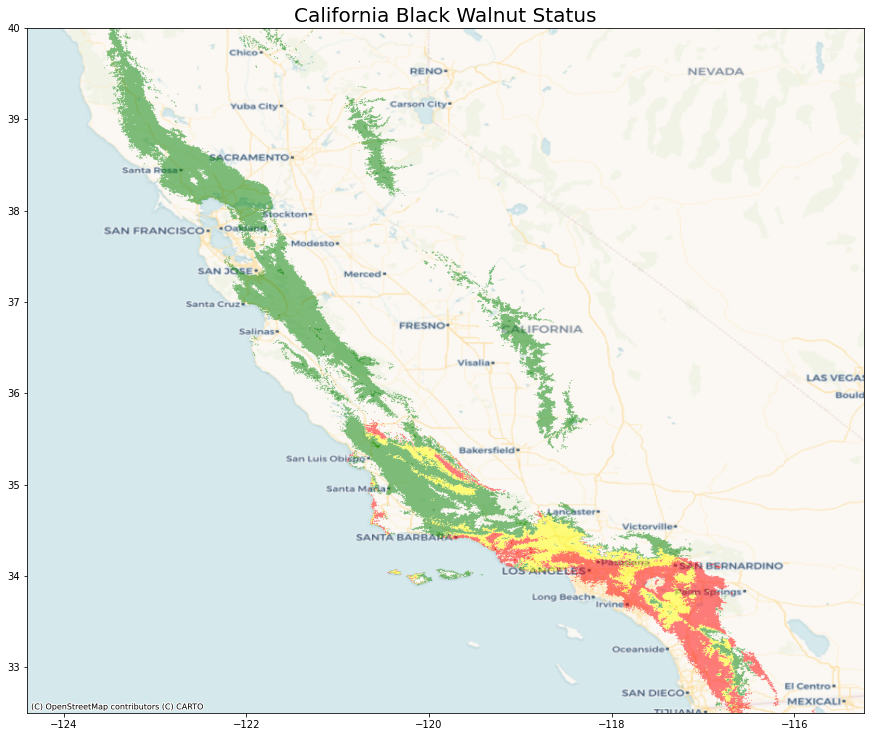

In [51]:
fig, ax = plt.subplots(figsize=(15,15))

helptreegdf.plot(ax=ax, color=helptreegdf.color, legend=True, alpha=.5)

# keeping the axis on for now and will turn off later
ax.axis('on')

ax.set_title('California Black Walnut Status',fontsize=20)

ax.set_ylim([32.5, 40])

# we are interested in seeing LA county map features and will use this basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager, crs=vacgdf.crs)

plt.savefig('California_blackwalnut_range.png', bbox_inches='tight')

In [52]:
# to map vacant parcels
fig, ax = plt.subplots(figsize=(15,15))

cmap = plt.get_cmap('rainbow')

helptreegdf.plot(ax=ax, 
                 alpha=0.2,
                 legend=True,
                color=helptreegdf.color)

vacgdf.plot(ax=ax, markersize=2,marker='D',
                      color='#FFFFFF',
            alpha=0.4)

elsereno.plot(ax=ax, edgecolor='k',
              linewidth=2,  
              color='none')

 plot(x,y)
 hold on
 plot(x(10),y(10),'r*')

ax.set_xlim([-118.275, -118.1])
ax.set_ylim([34, 34.24])

# keeping the axis on for now and will turn off later
ax.axis('off')

ax.set_title('Vacant Parcels in El Sereno and California Black Walnut Status',fontsize=20)

# we are interested in seeing LA county map features and will use this basemap
ctx.add_basemap(ax, source=ctx.providers.Stamen.Terrain, crs=vacgdf.crs)

plt.savefig('VacantParcels_Terrain.png', bbox_inches='tight')

IndentationError: unexpected indent (158483159.py, line 19)

In [ ]:
# to map vacant parcels
fig, ax = plt.subplots(figsize=(25,25))

elsereno.plot(ax=ax, edgecolor='k',linewidth=10, alpha=0.9, color='none')
helptreegdf.plot()

# keeping the axis on for now and will turn off later
ax.axis('on')

ax.set_title('Vacant Parcels in LA Incorporated',fontsize=30)

# we are interested in seeing LA county map features and will use this basemap
ctx.add_basemap(ax, source=ctx.providers.Stamen.Terrain, crs=vacgdf.crs)

plt.savefig('VacantParcels_Terrain.png', bbox_inches='tight')

In [ ]:
elsereno.bounds

In [ ]:
helptreegdf.crs

In [ ]:
gdf.loc[gdf['NEIGHBORHO'] == 'Chinatown', 'color'] = '#c80550'
gdf.loc[gdf['NEIGHBORHO'] == 'Downtown/Civic Center', 'color'] = '#677617'
gdf.loc[gdf['NEIGHBORHO'] == 'Western Addition', 'color'] = '#569abd'

gdf_web_mercator.plot(ax=ax, 

                      alpha=0.7,
                      color = gdf_web_mercator.color

In [ ]:
https://opendata.arcgis.com/datasets/909fd7034cc24a40aa82b3cf0a62da50_9.geojson